# DP0.2 Notebook 16 Galaxy Photometry

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact author(s): <i>Christina Williams</i> <br>
Last verified to run: <i>2024-11-18</i> <br>
LSST Science Pipelines version: Weekly <i>2024_24</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: 
(a) removed if it is not applicable to the notebook; 
or (b) replaced with text that is appropriate for the notebook. 
But bold or regular text should appear pretty much as-is in all CET notebooks._

_Remember to use the [CST's Guidelines for Tutorial Notebooks](rtn-045.lsst.io)._

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

> **Notice:** *use indented text preceded with* **Notice** *or* **Warning** *to attract attention to particular information.*

_Embedded images or generated figures should be captioned in a markdown cell, like this._

### 1.0 Selected text grabbed from Melissa's photo-z notebook (for now)
#### Schema: types of fluxes measured

Schema for the object catalog for DP0.2: https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object

For photometric redshifts, since accurate colors are important, it is the GaaP fluxes that should be used.

### Aperture fluxes
This contains the enclosed flux inside a given aperture (these are raw fluxes, meaning, they are not corrected to total fluxes using an aperture correction that accounts for the flux falling outside the aperture using the PSF). Fixed aperture diameter size in pixels.

```
<f>_ap<pix>Flux     : Flux within <pix>-pixel aperture. Forced on <f>-band.
<f>_ap<pix>FluxErr  : Uncertainty of <f>_ap<pix>Flux.
<f>_ap<pix>FluxFlag : Failure flag for <f>_ap<pix>Flux.
```

For DP0.2, the apertures are 3, 6, 9, 12, 17, 25, 35, 50, and 70 pixels.

In the column name, apertures are `03`, `06`, `09`, `12`, and so on.

### Composite Model (CModel) fluxes

Similar in nature to those measured for SDSS: 
https://www.sdss3.org/dr8/algorithms/magnitudes.php#cmodel

In short, it is the linear combination of the best fit exponential and de Vaucouleurs profiles.

```
<f>_cModelFlux    :	Flux from the final cmodel fit. Forced on <f>-band.
<f>_cModelFluxErr : Uncertainty of <f>_cModelFlux
<f>_cModel_flag   : Failure flag for <f>_cModelFlux
```

Fluxes fit to the individual model components.

```
<f>_bdFluxB    : Flux from the de Vaucouleurs fit. Measured on <f>-band.
<f>_bdFluxD    : Flux from the exponential fit. Measured on <f>-band.
<f>_bdFluxBErr : Uncertainty of <f>_bdFluxB
<f>_bdFluxDErr : Uncertainty of <f>_bdFluxD
```

The fit sizes are also available (half-light radii, ellipse axes).

### GaaP fluxes

The Gaussian-aperture-and-PSF flux from <a href="https://ui.adsabs.harvard.edu/abs/2008A%26A...482.1053K/abstract">Kuijken et al. 2008</a>.

**Optimal**

```
<f>_gaapOptimalFlux    : GaaP flux with optimal aperture after multiplying the seeing by 1.15. Forced on <f>-band.
<f>_gaapOptimalFluxErr : Uncertainty of <f>_gaapOptimalFlux.
```

**PSF**

```
<f>_gaapPsfFlux    : GaaP flux with PSF aperture after multiplying the seeing by 1.15. Forced on <f>-band.
<f>_gaapPsfFluxErr : Uncertainty of <f>_gaapPsfFlux.
```

**Aperture**

```
<f>_gaap<ap>Flux    : GaaP flux with <ap> aperture after multiplying the seeing by 1.15. Forced on <f>-band.
<f>_gaap<ap>FluxErr : Uncertainty of <f>_gaap<ap>Flux.
```

Where the apertures are 0.5, 0.7, 1.0, 1.5, 2.5, and 3.0.
In the column name `<ap>` appears as `0p5`, `0p7`, etc.


### Kron fluxes

A decent summary of Kron fluxes <a href="https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2_6.html">in the NED documentation</a>.

```
<f>_kronFlux      : Flux from Kron Flux algorithm. Measured on <f> g-band.
<f>_kronFluxErr   : Uncertainty of <f>_kronFlux.
<f>_kronFlux_flag : Failure flag for <f>_kronFlux.
```

The Kron radius, `<f>_kronRad`, is also available.

### PSF fluxes

Fluxes derived using the model point-spread function (PSF) of the image. The focus here should be static sky (calexp, deepCoadd) and extended objects (i.e. not PSF fluxes). Connect where relevant to the PSF tutorial and to the tutorial developed for SP-910 (is this Notebook 12a/b or 5?).

```
<f>_psfFlux      : Flux derived from linear least-squares fit of PSF model. Forced on <f>-band.
<f>_psfFluxErr   : Uncertainty of <f>_psfFlux.
<f>_psfFlux_flag : Failure flag for <f>_psfFlux.

```


### 1.1 Import packages


`numpy` is a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>).

`matplotlib` is a comprehensive library for creating static, animated, and
interactive visualizations in Python 
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>).

From the `lsst` package, modules for accessing the TAP service, the butler, and image display functions are imported (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>).

In [2]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord
import gc
import numpy as np

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.geom as geom

### 1.2 Define functions and parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

In [3]:
plt.style.use('tableau-colorblind10')
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
service = get_tap_service("tap")

## 2. Section heading

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section sub-heading

#### 2.1.1 Section sub-sub-heading

In [5]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

In [6]:
#fig, ax = plt.subplots()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(coadd.image)
#plt.show()
#remove_figure(fig)

In [7]:
skymap = butler.get('skyMap')
dataId = {'skymap': skymap, 'tract': 4431, 'patch': 17}


In [8]:
cutout_image = coadd

wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())

In [9]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, " + \
        "i_ap09Flux, i_ap12Flux, i_ap17Flux, i_ap25Flux, i_ap35Flux, " + \
        "i_cModelFlux, i_free_cModelFlux, " + \
        "i_gaap3p0Flux, i_gaap1p5Flux, i_gaapOptimalFlux, " + \
        "i_kronFlux, i_kronRad, i_kronFlux_flag, " + \
        "detect_fromBlend " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " + \
        str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " + \
        str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " + \
        str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1 AND " + \
        "detect_isPrimary = 1 AND " + \
        "tract = " + str(dataId['tract']) + " AND patch = " + str(dataId['patch'])
print(query)

SELECT objectId, coord_ra, coord_dec, x, y, tract, patch, i_ap09Flux, i_ap12Flux, i_ap17Flux, i_ap25Flux, i_ap35Flux, i_cModelFlux, i_free_cModelFlux, i_gaap3p0Flux, i_gaap1p5Flux, i_gaapOptimalFlux, i_kronFlux, i_kronRad, i_kronFlux_flag, detect_fromBlend FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), POLYGON('ICRS', 55.79016376401875, -32.322225378380246, 55.5140525810614, -32.32222523523597, 55.51440424131911, -32.088896406426095, 55.78981243851229, -32.088896548288034)) = 1 AND detect_isPrimary = 1 AND tract = 4431 AND patch = 17


In [10]:
query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, "\
        "obj.coord_ra, obj.coord_dec "\
        "obj.i_kronFlux, obj.i_kronRad, obj.i_kronFlux_flag, obj.i_cModelFlux, " + \
        "obj.i_cModelFlux, obj.i_free_cModelFlux, " + \
        "obj.i_gaap3p0Flux, obj.i_gaap1p5Flux, obj.i_gaapOptimalFlux, " + \
        "obj.detect_fromBlend  " + \
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1"


#"POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " + \
#        str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " + \
#        str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " + \
#        str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1" 
        #, CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "" 
# AND " + \
        #"obj.detect_isPrimary = 1 AND " + \
        #"obj.tract = " + str(dataId['tract']) + " AND obj.patch = " + str(dataId['patch'])

#CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "
print(query)

SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, obj.coord_ra, obj.coord_dec obj.i_kronFlux, obj.i_kronRad, obj.i_kronFlux_flag, obj.i_cModelFlux, obj.i_cModelFlux, obj.i_free_cModelFlux, obj.i_gaap3p0Flux, obj.i_gaap1p5Flux, obj.i_gaapOptimalFlux, obj.detect_fromBlend  FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1


In [11]:
query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, ts.flux_i, "\
        "obj.coord_ra, obj.coord_dec, "\
        "obj.i_kronFlux, obj.i_kronRad, obj.i_kronFlux_flag, obj.i_cModelFlux " + \
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "
print(query)

SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, ts.flux_i, obj.coord_ra, obj.coord_dec, obj.i_kronFlux, obj.i_kronRad, obj.i_kronFlux_flag, obj.i_cModelFlux FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 


In [12]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [13]:
results = job.fetch_result()
print(len(results))
tab = results.to_table()
tab

14850


id_truth_type,match_objectId,ra,dec,truth_type,flux_i,coord_ra,coord_dec,i_kronFlux,i_kronRad,i_kronFlux_flag,i_cModelFlux
,,deg,deg,,nJy,deg,deg,nJy,,,nJy
str18,int64,float64,float64,int64,float32,float64,float64,float64,float32,bool,float64
7945422126_1,1651220174314970042,62.0098537,-37.0901136,1,80.1357,62.0097847,-37.0901294,165.209455,3.96143,False,144.8895812
7945243448_1,1651220174314969053,62.0123662,-37.0958262,1,29.3619,62.0122497,-37.095827,26.3455006,3.35127,False,26.4549883
7943980583_1,1651220174314973031,62.0804319,-37.0599329,1,85.0716,62.0804585,-37.0599007,162.519251,5.77871,False,94.6220978
7945989161_1,1651220174314971178,62.0564371,-37.0798811,1,19.3238,62.0564774,-37.0798535,302.4945923,6.34324,False,26.7677409
7943914894_1,1651220174314972468,62.0265776,-37.0665263,1,97.0441,62.0265816,-37.0666442,88.0578177,2.17656,False,92.9627681
7945857828_1,1651220174314944411,62.0235745,-37.09605,1,17.5286,62.0237049,-37.0960033,894.5515387,7.43073,True,46.6692541
7952673851_1,1651220174314942424,62.0192451,-37.0681484,1,21.9923,62.0192534,-37.0680369,235.4698083,6.75986,True,16.5300362
7944426799_1,1651220174314944029,62.0598167,-37.078065,1,71.2611,62.0596735,-37.0780034,--,--,True,51.5588324


/tmp/ipykernel_9284/1456611101.py:3: RuntimeWarning: divide by zero encountered in log10
  cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
/tmp/ipykernel_9284/1456611101.py:3: RuntimeWarning: invalid value encountered in log10
  cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
/tmp/ipykernel_9284/1456611101.py:4: RuntimeWarning: divide by zero encountered in log10
  kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4
/tmp/ipykernel_9284/1456611101.py:4: RuntimeWarning: invalid value encountered in log10
  kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4


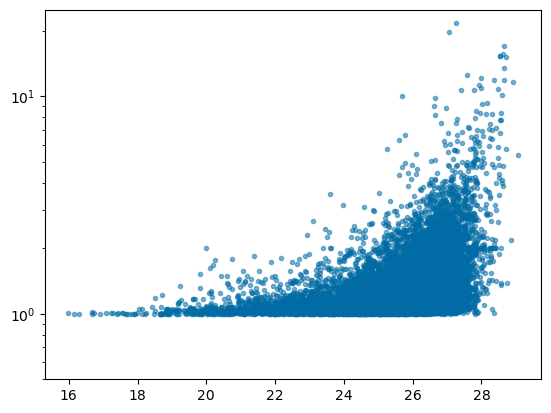

In [26]:
# this is where you are working here:

cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4
truth_mag =  -2.50 * np.log10(tab['flux_i']) + 31.4

#plt.scatter(truth_mag,cmodel_mag,c=tab['i_kronRad'], marker='.', alpha=.5)
fig, ax = plt.subplots()
ax.plot(truth_mag, 1+np.abs(tab['i_cModelFlux']-tab['flux_i'])/tab['flux_i'],'.',alpha=.5)

#ax.scatter(truth_mag,kron_mag,c=tab['i_kronRad'], marker='+', alpha=.5)

ax.set_ylim([0.5,25])
ax.set_yscale('log')
#plt.ylim(15,20)
#x = np.arange(14,30,.1)
#plt.plot(x,x,linestyle='--')
#plt.axhline(1,linestyle='--')

#plt.show()

In [ ]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'dp02_dc2_catalogs.Object'"

results = service.search(query).to_table()
results

In [16]:
search_string = 'Flux'
band = 'i_'
for cname in results['column_name']:
    if (cname.find(search_string) > -1) and (cname.find(band) > -1):
        print(cname)

i_ap03Flux
i_ap03Flux_flag
i_ap03FluxErr
i_ap06Flux
i_ap06Flux_flag
i_ap06FluxErr
i_ap09Flux
i_ap09Flux_flag
i_ap09FluxErr
i_ap12Flux
i_ap12Flux_flag
i_ap12FluxErr
i_ap17Flux
i_ap17Flux_flag
i_ap17FluxErr
i_ap25Flux
i_ap25Flux_flag
i_ap25FluxErr
i_ap35Flux
i_ap35Flux_flag
i_ap35FluxErr
i_ap50Flux
i_ap50Flux_flag
i_ap50FluxErr
i_ap70Flux
i_ap70Flux_flag
i_ap70FluxErr
i_apFlux_flag
i_apFlux_flag_apertureTruncated
i_apFlux_flag_sincCoeffsTruncated
i_bdFluxB
i_bdFluxBErr
i_bdFluxD
i_bdFluxDErr
i_calibFlux
i_calibFlux_flag
i_calibFlux_flag_apertureTruncated
i_calibFlux_flag_sincCoeffsTruncated
i_calibFluxErr
i_cModelFlux
i_cModelFlux_inner
i_cModelFluxErr
i_free_cModelFlux
i_free_cModelFlux_flag
i_free_cModelFlux_inner
i_free_cModelFluxErr
i_free_psfFlux
i_free_psfFlux_flag
i_free_psfFluxErr
i_gaap0p5Flux
i_gaap0p5Flux_flag_bigPsf
i_gaap0p5FluxErr
i_gaap0p7Flux
i_gaap0p7Flux_flag_bigPsf
i_gaap0p7FluxErr
i_gaap1p0Flux
i_gaap1p0Flux_flag_bigPsf
i_gaap1p0FluxErr
i_gaap1p5Flux
i_gaap1p5Flux_fla

In [17]:
tab

id_truth_type,match_objectId,ra,dec,truth_type,flux_i,coord_ra,coord_dec,i_kronFlux,i_kronRad,i_kronFlux_flag,i_cModelFlux
,,deg,deg,,nJy,deg,deg,nJy,,,nJy
str18,int64,float64,float64,int64,float32,float64,float64,float64,float32,bool,float64
7945422126_1,1651220174314970042,62.0098537,-37.0901136,1,80.1357,62.0097847,-37.0901294,165.209455,3.96143,False,144.8895812
7945243448_1,1651220174314969053,62.0123662,-37.0958262,1,29.3619,62.0122497,-37.095827,26.3455006,3.35127,False,26.4549883
7943980583_1,1651220174314973031,62.0804319,-37.0599329,1,85.0716,62.0804585,-37.0599007,162.519251,5.77871,False,94.6220978
7945989161_1,1651220174314971178,62.0564371,-37.0798811,1,19.3238,62.0564774,-37.0798535,302.4945923,6.34324,False,26.7677409
7943914894_1,1651220174314972468,62.0265776,-37.0665263,1,97.0441,62.0265816,-37.0666442,88.0578177,2.17656,False,92.9627681
7945857828_1,1651220174314944411,62.0235745,-37.09605,1,17.5286,62.0237049,-37.0960033,894.5515387,7.43073,True,46.6692541
7952673851_1,1651220174314942424,62.0192451,-37.0681484,1,21.9923,62.0192534,-37.0680369,235.4698083,6.75986,True,16.5300362
7944426799_1,1651220174314944029,62.0598167,-37.078065,1,71.2611,62.0596735,-37.0780034,--,--,True,51.5588324


/tmp/ipykernel_9284/2103441182.py:6: RuntimeWarning: divide by zero encountered in log10
  cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
/tmp/ipykernel_9284/2103441182.py:6: RuntimeWarning: invalid value encountered in log10
  cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
/tmp/ipykernel_9284/2103441182.py:7: RuntimeWarning: divide by zero encountered in log10
  kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4
/tmp/ipykernel_9284/2103441182.py:7: RuntimeWarning: invalid value encountered in log10
  kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4


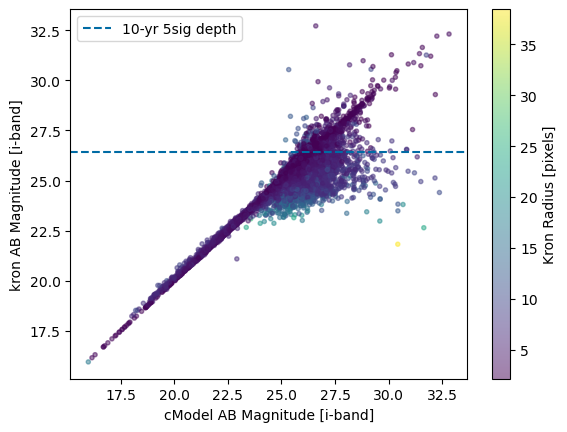

In [18]:
# compare kron mag to cmodel mag

#whbright = np.where(tab['i_kronFlux'] > 0.0001e6)[0]
whbright = np.where((tab['i_kronFlux'] > 0.01e6) & (tab['i_kronFlux_flag'] == 0))[0]

cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4

plt.scatter(cmodel_mag,kron_mag,
            c=tab['i_kronRad'], marker='.', alpha=.5)

#plt.scatter(cmodel_mag[whbright],kron_mag[whbright],
#            c=tab['i_kronRad'][whbright], marker='.', alpha=.5)
plt.axhline(26.4,linestyle='--',label='10-yr 5sig depth')

plt.colorbar(label='Kron Radius [pixels]')
plt.xlabel('cModel AB Magnitude [i-band]')
plt.ylabel('kron AB Magnitude [i-band]')
plt.legend()
plt.show()

In [19]:

cmodel_mag = -2.50 * np.log10(tab['i_gaapOptimalFlux']) + 31.4
kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4

plt.scatter(cmodel_mag,kron_mag,
            c=tab['i_kronRad'], marker='.', alpha=.5, vmin=1, vmax=50)

#plt.scatter(cmodel_mag[whbright],kron_mag[whbright],
#            c=tab['i_kronRad'][whbright], marker='.', alpha=.5)
plt.axhline(26.4,linestyle='--',label='10-yr 5sig depth')

plt.colorbar(label='Kron Radius [pixels]')
plt.xlabel('GaaP optimal AB Magnitude [i-band]')
plt.ylabel('kron AB Magnitude [i-band]')
plt.legend()
plt.show()

KeyError: 'i_gaapOptimalFlux'

In [ ]:

cmodel_mag = -2.50 * np.log10(tab['i_gaap1p5Flux']) + 31.4
kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4

plt.scatter(cmodel_mag,kron_mag,
            c=tab['i_kronRad'], marker='.', alpha=.5, vmin=1, vmax=50)

#plt.scatter(cmodel_mag[whbright],kron_mag[whbright],
#            c=tab['i_kronRad'][whbright], marker='.', alpha=.5)
plt.axhline(26.4,linestyle='--',label='10-yr 5sig depth')

plt.colorbar(label='Kron Radius [pixels]')
plt.xlabel('GaaP AB Magnitude 1.5 aperture [i-band]')
plt.ylabel('kron AB Magnitude [i-band]')
plt.legend()
plt.show()

In [ ]:

whbright = np.where((tab['i_kronFlux'] > 0.001e6) & (tab['i_kronFlux_flag'] == 0))[0]

mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4
plt.scatter(mag[whbright],tab['i_kronFlux'][whbright]/tab['i_cModelFlux'][whbright],
            c=tab['i_kronRad'][whbright], marker='o', alpha=.5, vmin=1, vmax=50)
plt.colorbar(label='Kron Radius [pixels]')
plt.axhline(1,linestyle='--')
plt.xlabel('Kron AB Magnitude [i-band]')
plt.yscale('log')
plt.ylabel('Kron flux / cModel Flux')


#whbad = np.where( (np.abs(tab['i_kronFlux'][whbright]/tab['i_cModelFlux'][whbright]) > 2) & (mag[whbright] < 22))[0]
whblend = np.where( tab['detect_fromBlend'][whbright] == True)[0]

print(tab['detect_fromBlend'][whbright][whbad])
plt.plot(mag[whbright][whblend],tab['i_kronFlux'][whbright][whblend]/tab['i_cModelFlux'][whbright][whblend],'k+')

plt.show()

In [ ]:
plt.scatter(tab['i_kronRad'][whbright],tab['i_kronFlux'][whbright]/tab['i_gaapOptimalFlux'][whbright],
            c=mag[whbright], marker='o', alpha=.5)
plt.xlabel('Kron Radius [pix]')
plt.ylabel('Kron flux / GaaP Optimal Flux')
plt.colorbar(label='Kron Mag [ABmag]')
plt.xlim([0,50])
plt.ylim([-1,30])
plt.show()

In [ ]:
plt.scatter(tab['i_kronRad'][whbright],tab['i_kronFlux'][whbright]/tab['i_cModelFlux'][whbright],
            c=mag[whbright], marker='o', alpha=.5)
plt.xlabel('Kron Radius [pix]')
plt.ylabel('Kron flux / cModel Flux')
plt.colorbar(label='Kron Mag [ABmag]')
plt.xlim([0,50])
plt.ylim([-1,30])
plt.show()